# __Step 4.4d Lowess fit and reorder heatmap__

Goal:
- Fit the original frequency data with lowess
- Apply criteria to sort topics after lowess fit
  - Primary: Timestamp when 1st each threshold freq (after min-max normalization)
  - Secondary: 1st peak location after reaching theshold freq
- Draw heatmap

Considerations:
- 2/24/24
  - Note that the sorting criteria is sort_ttp = ['Stable', 'Trend', '1st_reach_thr', 'Peak'].
- Best fit lowess
  - At frac=0.3, some data fit extremely well with a smooth curve and low MSE.
  - But for others with peculiar outlier data points, or early peak, frac=0.2 or even 0.1 is needed to catpure the trend better.
- Trend calling
  - As if there is up/down-ward trend or no change after the 1st peak.
  - In some situations, there are apparent downward trend in the last few data points. I have a hard time deciding how to call it. For example:
    - Topic 3 trended down, then up, then down 
    - Topic 8, trended down, then stable 
    - In these cases, the question is about whether in the last few time points, there is a clear downward trend. 

- 10/19/22 on topic ordering by applying the following criteria sequentially (the sortTTP scheme in the file names):
  - Defined as a stable topic or not
  - Trend (up/down, no change) 
  - Time when hitting the lowess fit value threshold 
  - Time when hitting the 1st peak after hitting the threshold

- 08/19/22 pick this back up
  - Continue in Step 9, Major down/up-ward trends per time point

## ___Set up___

### Import modules

In [1]:
# This following is done because:
# ImportError: cannot import name '_centered' from 'scipy.signal.signaltools
#https://stackoverflow.com/questions/71106940/cannot-import-name-centered-from-scipy-signal-signaltools 

import scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [591]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import minmax_scale
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from shutil import copy

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

### Set up data sources

In [40]:
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_4_over_time"

# topic freuqency for each timestamp
top_freq_file = work_dir / 'table4_4c_topic_frequency_per_timestamp.txt'

# series with topics as indices and timestamps with max lowess y as values
dir_lowess = work_dir / "_lowess"
dir_lowess.mkdir(parents=True, exist_ok=True)
ts_max_lowess_y_file = dir_lowess / "table4_4c_timestamps_with_max_y.txt"

# Copy plots and functions for specific frac values into the following folder
dir_lowess_sel = dir_lowess / "_selected"
dir_lowess_sel.mkdir(parents=True, exist_ok=True)

# topics as indices, timestamps as columns, lowess_y as values
lowess_df_file = dir_lowess / "table4_4c_toc_timestamps_lowess_vals.txt"

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# topic over tile file
tot_df_file = work_dir / "table4_4_topics_over_time_df_no_global_tune.tsv"


## ___Curve fitting: LOWESS___

### Function

In [4]:
def get_lowess(toc, x, y, frac, it=3, dir_lowess="dir_lowess", plot=0):

  lowess = sm.nonparametric.lowess
  lowess_fit = lowess(y, x, frac=frac, it=it) 
  lowess_x   = list(zip(*lowess_fit))[0]
  lowess_y   = list(zip(*lowess_fit))[1]

  # create a function using the interp1d method
  lowesss_f  = interp1d(lowess_x, lowess_y, bounds_error=False)

  # save the function
  f_file = dir_lowess / f"lowess_fit_func_topic{toc}_frac{frac}.pickle"
  with open(f_file, "wb") as f:
    pickle.dump(lowesss_f, f)

  #x_line = [i/10. for i in range(400)]
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), (max(x)-min(x))/100)
  y_line = lowesss_f(x_line)

  # For xtick labels
  x_date = [datetime.fromtimestamp(ts+1).strftime('%Y-%m-%d') for ts in lowess_x]

  # Create series
  lowess_ser = pd.Series(lowess_y, index=lowess_x, name=toc)

  if plot:
    # get 2 decimal points for mse
    mse = "{:.2f}".format(mean_squared_error(y, lowess_y))
    plt.title(f"topic {toc}, MSE={mse}")
    plt.plot(x, y, 'o')
    #plt.plot(lowess_x, lowess_y, '*')
    plt.plot(lowess_x, lowess_y, '*')
    #plt.plot(x_new, y_new, '-')
    plt.plot(x_line, y_line, '-')

    #https://stackabuse.com/rotate-axis-labels-in-matplotlib/
    plt.xticks(ticks=lowess_x, labels=x_date, rotation=90, fontsize=4)
    plt.xlabel("Date")
    plt.ylabel("Frequency")
    plt.ylim([0, max([max(y), max(lowess_y)])])
    plt.tight_layout()
    plt.savefig(dir_lowess / \
                            f'figure4_4c_topic_{toc}_lowess_frac{frac}.pdf')
    plt.close()
    
  return lowess_ser 

### Iterate through topics

In [5]:
# Load topic frequency for each timestamp
top_freq_df = pd.read_csv(top_freq_file, index_col=0)
topics = top_freq_df.index.tolist()

In [6]:
def fit_topics(frac, it):
  '''Lowess fit each topic and save the outputs
  Args:
    frac (float): The fraction of the data used when estimating each y-value.
    it (int): The number of residual-based reweightings to perform.
  Output:
    
  '''

  # Create a subfolder for the specific frac
  # Decide not to use this, so I can compare each fit side by side
  #dir_lowess_frac = dir_lowess / f"_{frac}"
  #dir_lowess_frac.mkdir(parents=True, exist_ok=True)

  max_y_idxs      = [] # indices (x, timestamps) with max y
  lowess_ser_list = [] # list of lowess-fitted series for different topics
  for toc in tqdm(topics):
    # series for the topic, timestamps as indices, frequencies as row
    toc_series = top_freq_df.loc[toc]
    x          = [float(ts) for ts in toc_series.index]  # timestamps
    y          = toc_series.values # frequencies

    # series after lowess smoothing
    lowess_ser = get_lowess(toc, x, y, frac, it, dir_lowess, plot=1)

    max_y_idx  = lowess_ser.idxmax()
    max_y_idxs.append(max_y_idx)
    lowess_ser_list.append(lowess_ser)

  # for topic order
  max_y_idxs_ser = pd.Series(max_y_idxs, index=topics, name='max_y_timestamp')
  max_y_idxs_ser.to_csv(dir_lowess / \
                      f"table4_4c_timestamps_with_max_y_lowess_frac{frac}.txt")
  
  # Create a dataframe with lowess fits
  #https://sparkbyexamples.com/pandas/pandas-create-dataframe-from-multiple-series/
  lowess_df = pd.concat(lowess_ser_list, axis=1).transpose()

  # Sort the dataframe based on timestamps
  #https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-based-on-column-names-or-row-index/
  lowess_df.sort_index(inplace=True, axis=1)

  # Save the dataframe to file
  lowess_df.to_csv(dir_lowess / \
                          f"table4_4c_toc_timestamps_lowess_vals_{frac}.txt")

  return max_y_idxs_ser, lowess_df

In [7]:
max_y_idxs_ser01, lowess_df01 = fit_topics(0.1, 3)

100%|██████████| 91/91 [00:43<00:00,  2.08it/s]


In [10]:
max_y_idxs_ser02, lowess_df02 = fit_topics(0.2, 3)

100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


In [11]:
max_y_idxs_ser03, lowess_df03 = fit_topics(0.3, 3)

100%|██████████| 91/91 [00:30<00:00,  3.01it/s]


### Select reasonable fit for topics

In [12]:
# Just to make my life easier in the manual input step below
print(" ".join([f"{toc}:0.," for toc in topics]))

-1:0., 0:0., 1:0., 2:0., 3:0., 4:0., 5:0., 6:0., 7:0., 8:0., 9:0., 10:0., 11:0., 12:0., 13:0., 14:0., 15:0., 16:0., 17:0., 18:0., 19:0., 20:0., 21:0., 22:0., 23:0., 24:0., 25:0., 26:0., 27:0., 28:0., 29:0., 30:0., 31:0., 32:0., 33:0., 34:0., 35:0., 36:0., 37:0., 38:0., 39:0., 40:0., 41:0., 42:0., 43:0., 44:0., 45:0., 46:0., 47:0., 48:0., 49:0., 50:0., 51:0., 52:0., 53:0., 54:0., 55:0., 56:0., 57:0., 58:0., 59:0., 60:0., 61:0., 62:0., 63:0., 64:0., 65:0., 66:0., 67:0., 68:0., 69:0., 70:0., 71:0., 72:0., 73:0., 74:0., 75:0., 76:0., 77:0., 78:0., 79:0., 80:0., 81:0., 82:0., 83:0., 84:0., 85:0., 86:0., 87:0., 88:0., 89:0.,


In [501]:
# Go through the PDFs of different frac values for each topic and decide on
# which one to pick for presenting

# 3: the peak at 1992-08 is missing after fitting
# -1: outlier, exclude
# 5: Low #, for specific journal, exclude
# 59: missing peak at 1996-07, 2003-03
# 65: missing peak at 2007-09
# 73: missing peak at 2008-11
# 76: missing peak at 2008-11
# 77: low #, specific journal, exclude
# 81: missing peak at 2003-12
toc_fit_frac = \
 { 0:0.2,  1:0.1,  2:0.3,  3:0.2,  4:0.3,  6:0.3,  7:0.1,  8:0.2,  9:0.3, 
  10:0.3, 11:0.3, 12:0.1, 13:0.2, 14:0.3, 15:0.3, 16:0.3, 17:0.3, 18:0.1, 
  19:0.3, 20:0.2, 21:0.2, 22:0.1, 23:0.3, 24:0.3, 25:0.3, 26:0.2, 27:0.2,
  28:0.3, 29:0.2, 30:0.2, 31:0.3, 32:0.1, 33:0.3, 34:0.3, 35:0.1, 36:0.2, 
  37:0.1, 38:0.1, 39:0.1, 40:0.2, 41:0.3, 42:0.3, 43:0.2, 44:0.1, 45:0.1,
  46:0.2, 47:0.1, 48:0.1, 49:0.1, 50:0.1, 51:0.1, 52:0.1, 53:0.2, 54:0.3, 
  55:0.3, 56:0.3, 57:0.2, 58:0.2, 59:0.2, 60:0.3, 61:0.1, 62:0.1, 63:0.1, 
  64:0.2, 65:0.3, 67:0.1, 68:0.2, 69:0.1, 70:0.3, 71:0.3, 72:0.3, 
  73:0.2, 74:0.1, 75:0.3, 76:0.2, 78:0.2, 79:0.3, 80:0.2, 81:0.1, 82:0.3, 
  83:0.2, 84:0.2, 85:0.3, 86:0.2, 87:0.2, 88:0.3, 89:0.3}

stable = [4,53,56,58,61,81]

# After peak, trending up (1), no change (0), down (-1) 
top_fit_trend = \
 { 0:-1,  1:-1,  2:1,  3:1,  4:0,  6:-1,  7:-1,  8:-1,  9:0, 
  10:-1, 11:0, 12:-1, 13:0, 14:1, 15:-1, 16:0, 17:-1, 18:-1, 
  19:1, 20:-1, 21:-1, 22:-1, 23:1, 24:0, 25:0, 26:0, 27:-1,
  28:0, 29:-1, 30:0, 31:1, 32:-1, 33:0, 34:1, 35:-1, 36:1, 
  37:-1, 38:-1, 39:-1, 40:1, 41:1, 42:1, 43:1, 44:-1, 45:-1,
  46:0, 47:-1, 48:-1, 49:-1, 50:-1, 51:-1, 52:-1, 53:0, 54:0, 
  55:1, 56:-1, 57:1, 58:-1, 59:-1, 60:1, 61:0, 62:-1, 63:-1, 
  64:-1, 65:-1, 67:-1, 68:1, 69:-1, 70:1, 71:1, 72:0, 
  73:0, 74:0, 75:-1, 76:-1, 78:-1, 79:1, 80:1, 81:0, 82:1, 
  83:0, 84:1, 85:1, 86:-1, 87:0, 88:-1, 89:-1}

# Set what topics to drop for later
tocs_to_drop = [-1, 5, 66, 77]

In [502]:
# Copy specified plots and functions
#https://stackoverflow.com/questions/33625931/copy-file-with-pathlib-in-python
def copy_lowess_file(f_name):
  fr_file = Path(dir_lowess     / f_name)
  to_file = Path(dir_lowess_sel / f_name)
  copy(fr_file, to_file)

for toc in toc_fit_frac:
  frac             = toc_fit_frac[toc]
  lowess_func_file = f"lowess_fit_func_topic{toc}_frac{frac}.pickle"
  lowess_plot_file = f"figure4_4c_topic_{toc}_lowess_frac{frac}.pdf"
  copy_lowess_file(lowess_func_file)
  copy_lowess_file(lowess_plot_file)

In [503]:
len(toc_fit_frac.keys())

87

### Get the lowess fit values for topics based on selected frac values

In [504]:
# Create a list for holding series containing timestamp/freq values for 
# different topics
lowess_vals_list = []
for toc in toc_fit_frac:
  frac = toc_fit_frac[toc]
  lowess_df = lowess_df01
  if frac == 0.2:
    lowess_df = lowess_df02
  elif frac == 0.3:
    lowess_df = lowess_df03

  lowess_series = lowess_df.loc[toc]
  lowess_vals_list.append(lowess_series)

len(lowess_vals_list)

87

In [505]:
# Dataframe with lowess fitted freq values based on selected fits
lowess_df_sel = pd.concat(lowess_vals_list, axis=1).transpose()
lowess_df_sel.shape

(87, 50)

### Determine peak values

Criteria:
1. Value is above threshold after normalization
2. Value is at where the sign of slope change from positive to negative

In [632]:
peak_idxs    = {} # {toc:peak}
toc_thr_idxs = {} # {toc: idx_when_first_reach_threshold_value}
thr          = 0.6 # threshould values to store and to call peak

for toc in lowess_df_sel.index:
  #print(toc)
  toc_lowess_vals = lowess_df_sel.loc[toc]

  # do min-max normalization
  min_val   = np.min(toc_lowess_vals)
  max_val   = np.max(toc_lowess_vals)
  norm_vals = [(lowess_val-min_val)/(max_val-min_val) \
                                            for lowess_val in toc_lowess_vals]
  
  # find the peak position
  # iterate through value pairs
  #https://stackoverflow.com/questions/5764782/iterate-through-pairs-of-items-in-a-python-list
  peak = 0
  idx  = 1
  
  cumulative_diff = 0 
  for val1, val2, val3 in zip(norm_vals[:-2], norm_vals[1:-1], norm_vals[2:]):

    # Set the first time passing threshould for sorting purpose later
    if val1 > thr and toc not in toc_thr_idxs:
      toc_thr_idxs[toc] = idx-1
    elif val2 > thr and toc not in toc_thr_idxs:
      toc_thr_idxs[toc] = idx

    # For determining if this topic has continuously increasing or decreasing
    cumulative_diff += (val2 - val1) + (val3-val2)
    # detect if slope change from + to -
    if val2 > val1 and val3 < val2:
      if val2 > thr:
        peak = idx
        #print(" peak=",peak, [val1, val2, val3])
        break
    idx += 1

  # Did not find an inflection point
  if peak == 0:
    # upward trend, otherwise a downward trend and peak=0
    if cumulative_diff > 0: 
      peak = idx
      #print(" peak=", idx, cumulative_diff)

  # Check if toc_med_idxs is set for this toc
  if toc not in toc_thr_idxs:
    # The 1st value is >0.5 and the rest is not
    if norm_vals[0] > thr:
      toc_thr_idxs[toc] = 0
    else:
      print("ERR: toc_thr_idxs not set for topic", toc)

  peak_idxs[toc] = peak

In [633]:
# Create dataframes with:
# 1. peak indexes, 
# 2. toc threshould met index
# 3. toc trend
# 4. stable or not
peak_idxs_df = pd.DataFrame.from_dict(peak_idxs, orient='index', 
                                                      columns=['Peak'])
toc_thr_idxs_df = pd.DataFrame.from_dict(toc_thr_idxs, orient='index', 
                                                      columns=['1st_reach_thr'])
toc_trend_idx_df = pd.DataFrame.from_dict(top_fit_trend, orient='index',
                                                      columns=['Trend'])

#https://www.datacamp.com/tutorial/python-dictionary-comprehension
toc_stable_dict = {toc:(1 if toc in stable else 0) \
                                                for toc in lowess_df_sel.index}
toc_stable_df = pd.DataFrame.from_dict(toc_stable_dict, orient='index', 
                                                      columns=['Stable'])
                                                      
peak_idxs_df.shape, toc_thr_idxs_df.shape, toc_trend_idx_df.shape, toc_stable_df.shape

((87, 1), (87, 1), (87, 1), (87, 1))

In [634]:
peak_df = pd.concat([peak_idxs_df, toc_thr_idxs_df, 
                     toc_trend_idx_df, toc_stable_df], axis=1)
peak_df.head()

,Peak,1st_reach_thr,Trend,Stable
0,6,2,-1,0
1,3,1,-1,0
2,49,27,1,0
3,15,13,1,0
4,0,0,0,1


### Reordering

In [635]:
# Sort based on four criteria for flotting purpose later. 
# Realize that sorting peak 1st is not as good. So use sort_tp
sort_tp  = ['Stable', '1st_reach_thr', 'Peak', 'Trend']
sort_pt  = ['Stable', 'Peak', '1st_reach_thr', 'Trend']
sort_ttp = ['Stable', 'Trend', '1st_reach_thr', 'Peak']


# Stable on top of graph, pcolormesh draw from the bottom up based on the df
#https://www.geeksforgeeks.org/how-to-sort-a-pandas-dataframe-by-multiple-columns-in-python/
peak_df.sort_values(by=sort_ttp, inplace=True, 
                    ascending=[True, False, False, False])

# Save as txt
peak_df.to_csv(dir_lowess_sel / \
  f"Table4_4c_topic_peak_1st-reach_med_index_thr{thr}.txt")
peak_df.head()


,Peak,1st_reach_thr,Trend,Stable
82,49,36,1,0
85,49,32,1,0
14,49,31,1,0
23,49,31,1,0
55,49,31,1,0


## ___Draw heatmap with lowess fitted values___

### Reorder lowess freq value df

In [636]:
# dataframe ordered based on peak index values
order_idxs = peak_df.index.tolist()

lowess_df_sel_ord = lowess_df_sel.reindex(order_idxs)
lowess_df_sel_ord.head(2)

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
82,5.067435,6.306087,7.548692,8.323014,9.944502,11.948171,15.292584,19.450616,23.873708,27.787156,...,95.668587,98.734571,103.329250,107.916825,112.233403,116.579252,120.689424,124.655420,128.434774,131.904256
85,10.897201,16.184397,19.836729,22.621625,25.905777,29.253767,34.548858,41.782369,50.662335,59.244391,...,165.929885,169.576109,175.797906,183.050225,190.102959,197.280788,204.089143,210.680973,217.018120,222.896115


In [637]:
lowess_df_sel_ord.tail(2)

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
58,97.178176,86.984500,80.472426,76.517646,74.584455,76.120300,78.114249,78.369312,74.454493,71.042939,...,52.025335,52.229906,51.645375,51.683978,52.899919,52.162072,50.417158,48.361591,46.220563,44.187185
56,43.622197,43.528338,43.553967,43.751938,43.450254,43.177838,43.294571,44.097041,44.775103,44.730867,...,24.497630,24.283446,24.072202,24.069661,24.097166,24.154066,24.243600,24.364990,24.506355,24.657265


### Create a dataframe with normalized lowess freq

In [638]:
# Firstcreate a nested list where each element is a list of freq for a topic
tocs = lowess_df_sel_ord.index.tolist()
# topic over time frequency nested list
tot_freq = []

for topic in tocs:

  # frequency for each timestamp
  freq = lowess_df_sel_ord.loc[topic].values.tolist()

  # min-max scaling
  min_val = np.min(freq)
  max_val = np.max(freq)
  freq_norm = [(val-min_val)/(max_val-min_val) for val in freq]

  tot_freq.append(freq_norm)

In [639]:
# Get timestamps
ts_unique   = [float(ts) for ts in lowess_df_sel_ord.columns]

# Create a dataframe from the nested list
tot_freq_df = pd.DataFrame(tot_freq, columns=ts_unique)

# The nested list already follow the sorted index (idxs) so here just set index
tot_freq_df.index = order_idxs
tot_freq_df.head()

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
82,0.000000,0.009766,0.019563,0.025667,0.038452,0.054249,0.080617,0.113399,0.148271,0.179126,...,0.714313,0.738485,0.774710,0.810880,0.844912,0.879175,0.911581,0.942849,0.972646,1.0
85,0.000000,0.024940,0.042168,0.055304,0.070796,0.086588,0.111565,0.145685,0.187572,0.228054,...,0.731290,0.748489,0.777838,0.812047,0.845315,0.879172,0.911287,0.942381,0.972273,1.0
14,0.000000,0.012692,0.023408,0.031157,0.044495,0.057837,0.081723,0.119769,0.158897,0.194014,...,0.729353,0.749261,0.775499,0.805217,0.836911,0.870692,0.903795,0.936615,0.968968,1.0
23,0.000000,0.015186,0.026665,0.034519,0.045294,0.056896,0.072087,0.092168,0.113289,0.131483,...,0.766443,0.790392,0.821085,0.849251,0.875991,0.903234,0.929172,0.954205,0.978071,1.0
55,0.108442,0.065048,0.039997,0.017473,0.004206,0.000000,0.021780,0.061216,0.099903,0.136898,...,0.714170,0.732490,0.763055,0.798079,0.832149,0.867475,0.901811,0.935741,0.968855,1.0


### Set up x axis

In [640]:
# Set heatmap x-axis
ts_begin = datetime(1971, 1, 1).timestamp()
boundsX  = np.insert(ts_unique, 0, ts_begin)

# Get the dates of unique timestamps to label x-axis
ts_unique_dts = [datetime.fromtimestamp(ts) for ts in ts_unique]
ts_unique_dts = [f"{dt.year}-{dt.month}-{dt.day}" for dt in ts_unique_dts]
xticklabels   = ["1917-1-1"] + ts_unique_dts

len(ts_unique), len(ts_unique_dts), len(boundsX), len(xticklabels)

(50, 50, 51, 51)

### Set up y axis

In [641]:
# Set heatmap y-axis
num_topics    = len(order_idxs)
toc_nooutlier = np.arange(num_topics)
midpointsY = (toc_nooutlier[:-1] + toc_nooutlier[1:]) / 2
boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                            midpointsY, 
                            [2*midpointsY[-1]-midpointsY[-2]]])

In [642]:
# Set yticklabels based on modified names
toc_mod_names = pd.read_csv(toc_mod_name_file, names=["Topic", "Mod_name"], 
                            sep='\t')
toc_mod_names = toc_mod_names.set_index('Topic')

# Drop three topics
toc_mod_names.drop(tocs_to_drop, inplace=True)
toc_mod_names.shape

(87, 1)

In [643]:
# order the topics
toc_mod_names_ordered = toc_mod_names.loc[order_idxs]
toc_mod_names_ordered.head(2), toc_mod_names_ordered.tail(2)

(                                                Mod_name
 Topic                                                   
 82     bacterial | soil | community | rhizosphere | f...
 85              soil | yield | nitrogen | water | stress,
                                                 Mod_name
 Topic                                                   
 58               polysaccharide | cell | wall | activity
 56     strains | rhizobium | nodules | bacteria | sym...)

In [644]:
# Two kinds of yticklabels
yticklabels          = order_idxs
yticklabels_modnames = toc_mod_names_ordered['Mod_name'].values.tolist()

### Plot heatmap

In [645]:
# Plotting
def plot_scaled_heatmap(df, fig_name, yticklabels=yticklabels):
  fig, ax = plt.subplots(figsize=(10,18))
  plot = ax.pcolormesh(boundsX, boundsY, df, cmap="RdPu")
  ax.set_xticks(boundsX)
  ax.set_xticklabels(xticklabels, rotation=90)
  ax.set_yticks(np.arange(len(order_idxs)))
  ax.set_yticklabels(yticklabels)
  ax.grid(False)
  fig.colorbar(plot)

  plt.tight_layout()
  plt.savefig(work_dir / fig_name)
  plt.show()

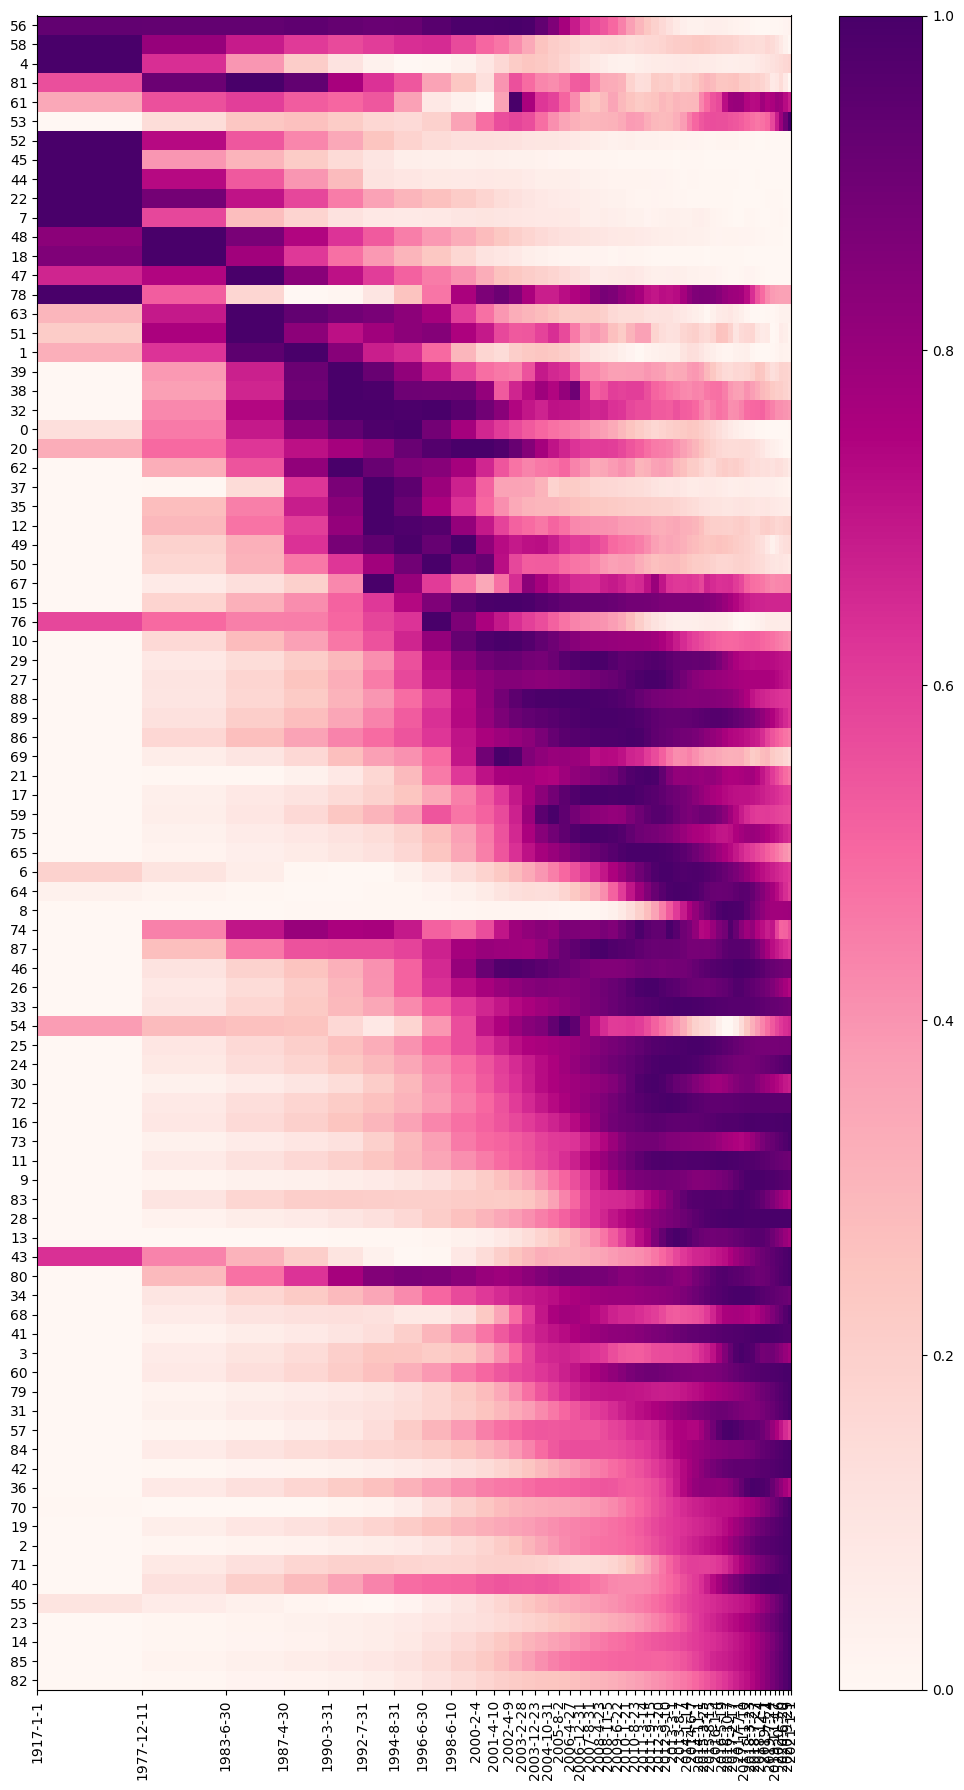

In [646]:
fig_name = 'fig4_4c_tot_heatmap_lowess-fit_lowess-order_xscaled_' + \
           f'no_globaltune_thr{thr}_sortTTP.pdf'
plot_scaled_heatmap(tot_freq_df, fig_name)

## ___Draw heatmap with original values___

### Get tot_freq_df and reorder based on idxs

In [647]:
topics_over_time = pd.read_csv(tot_df_file, sep='\t', index_col=0)
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"cells, growth, acid, activity, tissue",981,2.507508e+08
1,0,"timothy, timothy pollen, antigen, ragweed, all...",8,2.507508e+08
2,1,"callus, medium, kinetin, culture, protoplasts",85,2.507508e+08
3,2,"berberinium, viscometric titrations, flow pola...",2,2.507508e+08
4,3,"amiben, atrazine, gsatrazine, atrazine metabol...",4,2.507508e+08
...,...,...,...,...
4457,85,"soil, yield, nitrogen, ha1, stress",221,1.609477e+09
4458,86,"dispersal, genetic, populations, evolution, sp...",66,1.609477e+09
4459,87,"flowers, floral, pollinator, bees, pollination",72,1.609477e+09
4460,88,"genetic, populations, diversity, genetic diver...",71,1.609477e+09


In [648]:
# Create a nested list where each element is a list of frequencies for a topic
#tocs = topics_over_time.Topic.unique()
#tocs.sort()

# use the order_idxs as tocs
tocs = order_idxs

#print(tocs)
tot_freq = []
toc_outlier_modify = [57, 75, 76, 54, 73]
for topic in tocs:

  # topics_over_time sub-dataframe for a topic
  toc_data = topics_over_time.loc[topics_over_time.Topic == topic, :]
  # timestamps
  tss      = toc_data.Timestamp.values.tolist()
  # frequency for each timestamp
  freq = toc_data.Frequency.values.tolist()
  # Deal with max values in the five topics specified
  if topic in toc_outlier_modify:
    # index of max value
    idx_max    = freq.index(max(freq))
    # create a new list and remove the max value
    freq_copy = freq.copy()
    freq_copy.remove(max(freq))
    # index of the second max value
    idx_2ndmax = freq_copy.index(max(freq_copy))
    # set max value to 120% of the 2nd max value
    freq[idx_max] = freq[idx_2ndmax]*1.2

  # turn freq into a 2D array of shape (1, len(freq)), 
  freq = np.reshape(freq, (1, len(freq)))
  # min-max scale freq and get the 1d array back
  freq = minmax_scale(freq, axis=1)[0]

  # Check if all 50 timestamp bins are present, if not, fill in zero.
  freq_50  = []
  for ts in ts_unique:
    if ts in tss:
      idx = tss.index(ts)
      freq_50.append(freq[idx])
    else:
      freq_50.append(0)

  tot_freq.append(freq_50)

In [649]:
# topic over time freuqency, original values
tot_freq_ori_df = pd.DataFrame(tot_freq, columns=ts_unique)
tot_freq_ori_df.index = tocs
tot_freq_ori_df.shape

(87, 50)

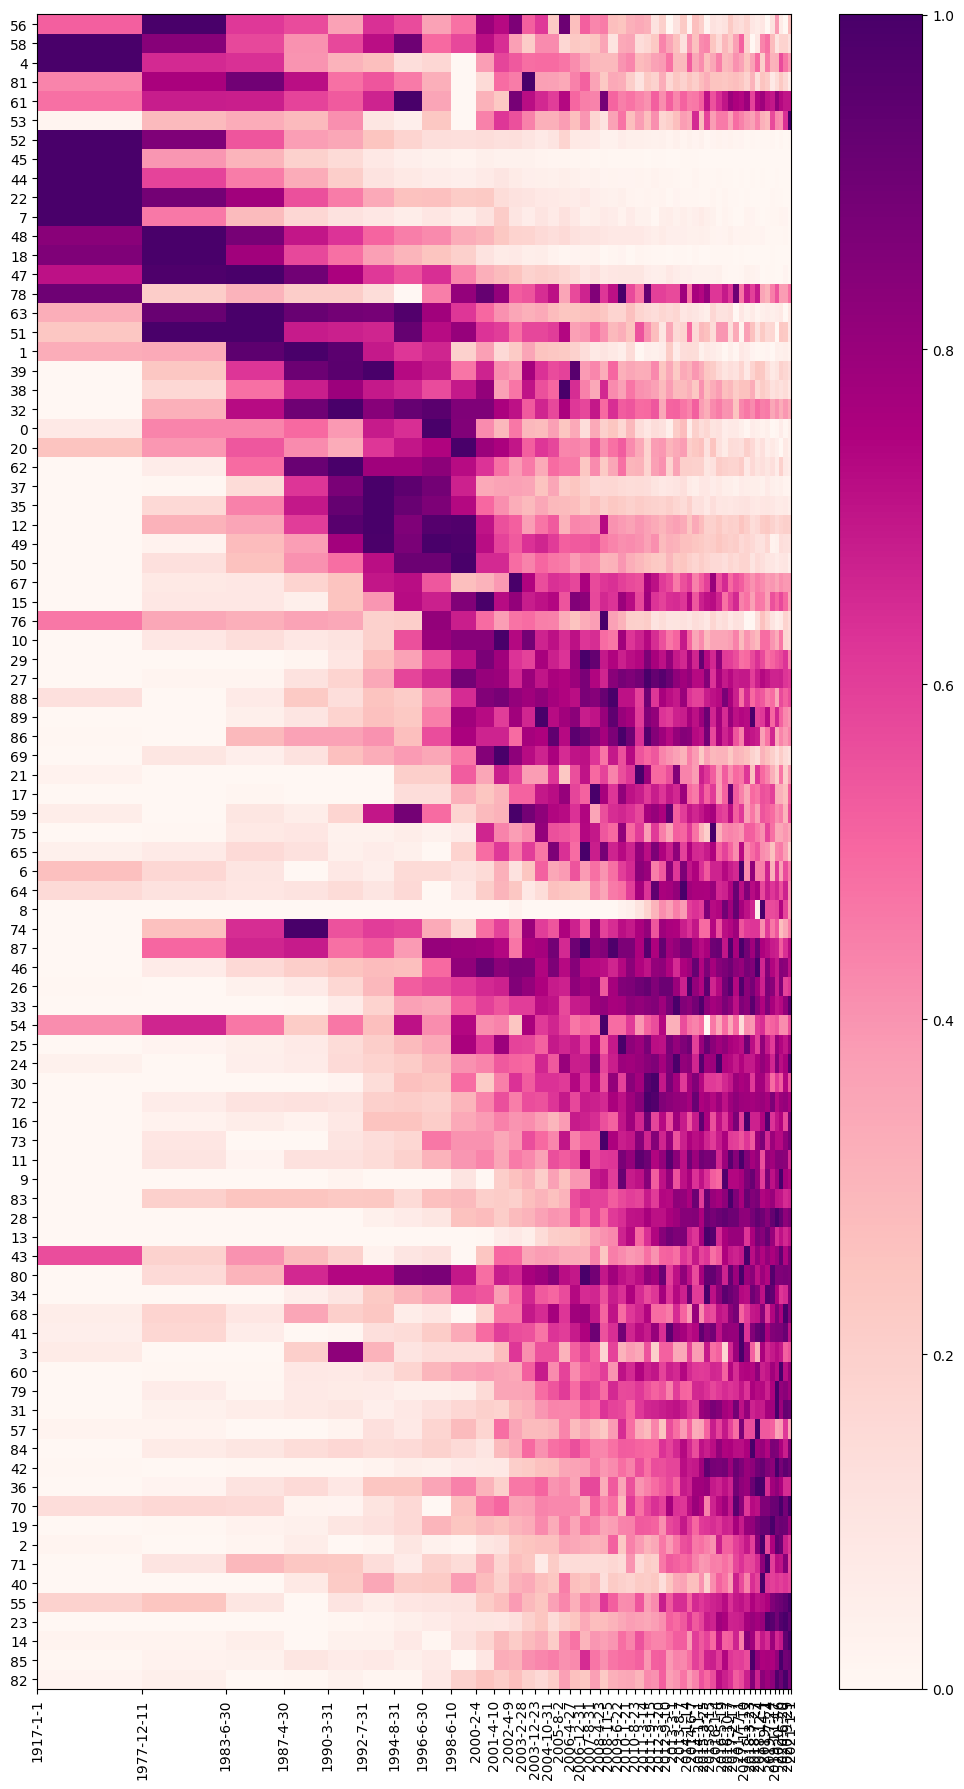

In [650]:
fig_name_ori = 'fig4_4c_tot_heatmap_ori-value_lowess-order_xscaled_' + \
               f'no_globaltune_thr{thr}_sortTTP.pdf'
plot_scaled_heatmap(tot_freq_ori_df, fig_name_ori)

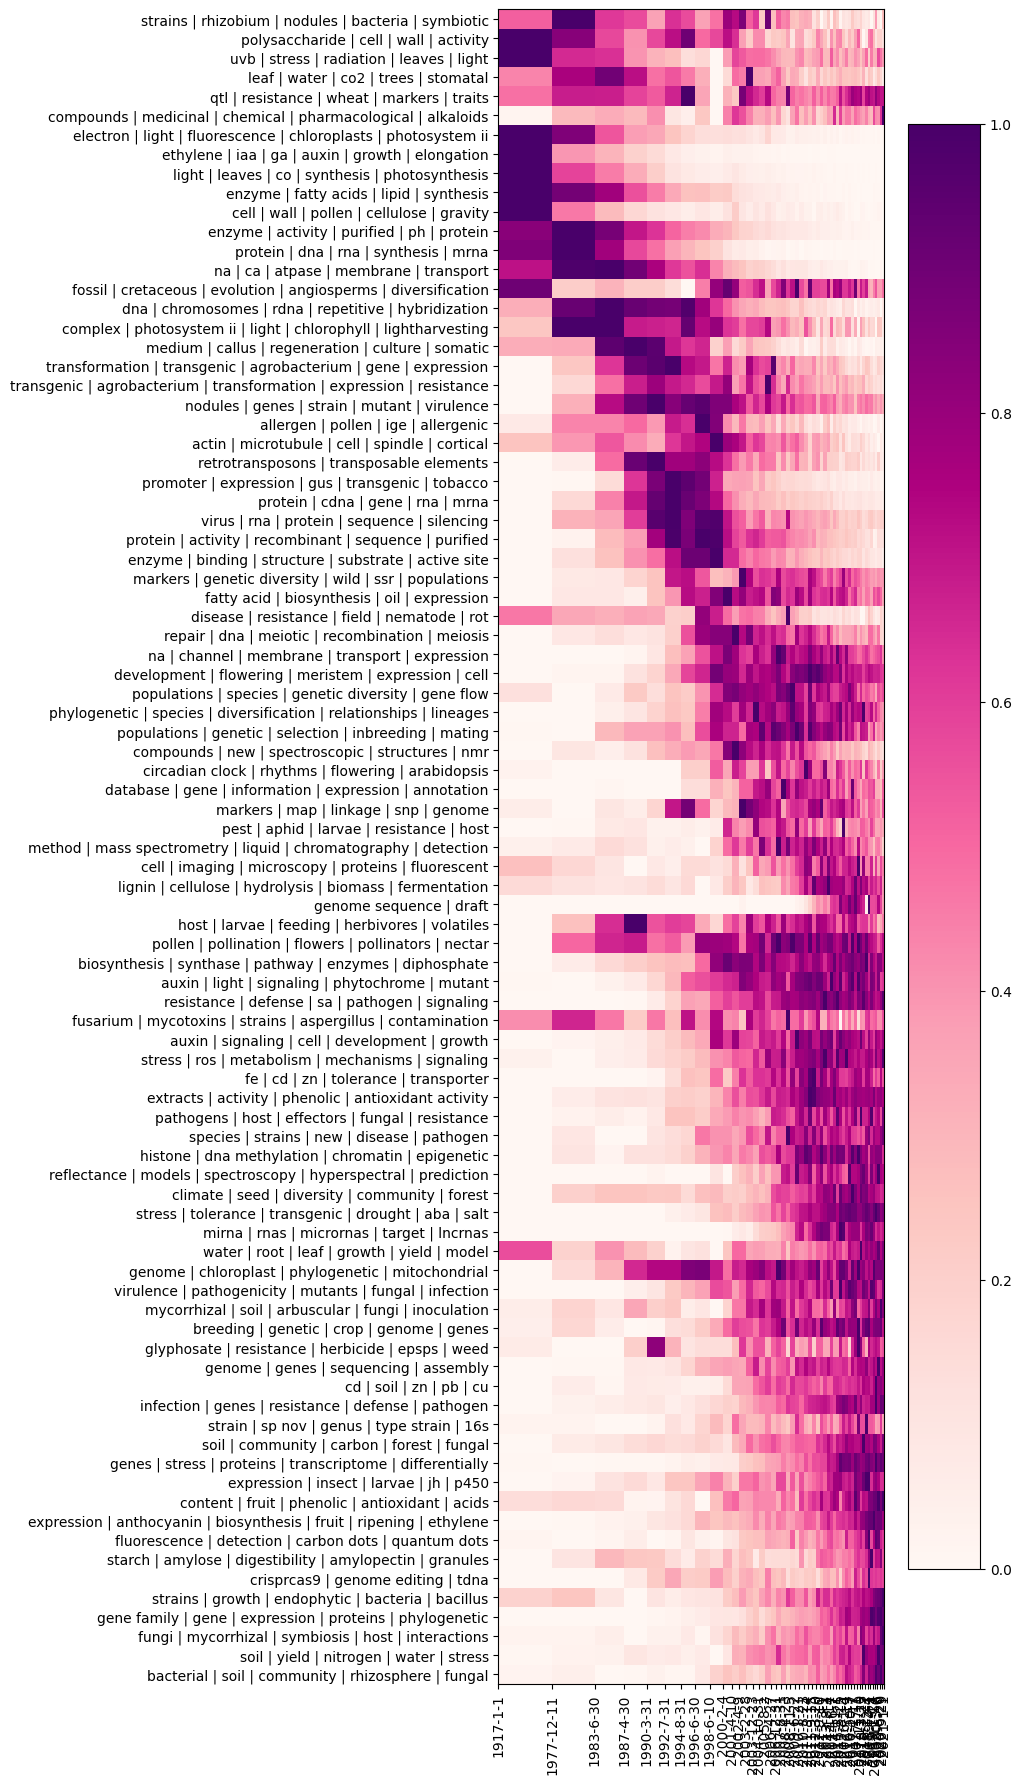

In [651]:
# with topic mod names as yticklabels
fig_name_ori2 = 'fig4_4c_tot_heatmap_ori-value_lowess-order_xscaled_' + \
               f'no_globaltune_thr{thr}_sortTTP_modnames.pdf'
plot_scaled_heatmap(tot_freq_ori_df, fig_name_ori2, yticklabels_modnames)

### Output current order

## ___Code dev___

### Get topic order

This is not used. The max_lowess_y is not a good criteria.

In [652]:
# topics as indices, row is the timestamp values as max lowess ys
ts_max_lowess_y = pd.read_csv(ts_max_lowess_y_file, index_col=0)

# sort dataframe based on row values
ts_max_lowess_y.sort_values(by='max_y_timestamp', inplace=True)
ts_max_lowess_y

FileNotFoundError: [Errno 2] No such file or directory: '/home/shius/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/table4_4c_timestamps_with_max_y.txt'

In [ ]:
# remove outlier topic
ts_max_lowess_y_drop_outlier = ts_max_lowess_y.drop(-1)

In [ ]:
# Indices (topics) in order of timestamps with max lowess y
idxs = ts_max_lowess_y_drop_outlier.index
idxs, len(idxs)